In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline


In [15]:
# function for reading the data files
def build_data_frame(path):
    rows = []
    index = []
    classification =[]
    for file_name, text, classification in read_files(path):
        rows.append({'text':text, 'class': classification})
        index.append(file_name)
        
    data_frame = pd.DataFrame(rows,index=index)
    return data_frame

In [16]:
def read_files(path):
    newline=''
    for root, dir_names, file_names in os.walk(path):
        print('Root folder: {0}'.format(root))
        print('Number of files read: {0}'.format(len(file_names)))
        for file_name in file_names:
            file_path = os.path.join(root,file_name)
            if(os.path.isfile(file_path)):
                #print(file_name)
                if("D" in file_name):
                    label="D"
                elif("R" in file_name):
                    label="R"
                else:
                    label="X"
                lines = []
                f = open(file_path)
                for line in f:
                    lines.append(line.rstrip("\n"))
                f.close()
                content=newline.join(lines)
                yield file_name, content, label

In [17]:
# here I set the path of data set using os.getcwd()
path = os.path.join(os.getcwd(), 'data_set')
# intitalize the empty data frame
data = pd.DataFrame({'text':[],'class':[]})
# call the function to build the data set
data=data.append(build_data_frame(path))

Root folder: C:\Users\abhis\AnacondaProjects\Speech-classification\data_set
Number of files read: 856


In [18]:
#Parse file name, reorder columns and print to csv

file_name = pd.Series(data.index.values)
bill, speaker, meta_date, file_name= file_name.str.split('_').str
data['bill_id'] = bill.values
data['speaker_id'] = speaker.values
data['meta_date'] = meta_date.values
data = data[['meta_date', 'speaker_id', 'class', 'bill_id', 'text']]
data.to_csv('clean_data.csv')

### Pipeline for executing the task

In [114]:
# using Pipeline 

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

f1_R = make_scorer(f1_score,pos_label='R')
f1_D = make_scorer(f1_score,pos_label='D')

ngrams = [(1,1),(1,2),(1,3),(1,4),(2,2),(2,3),(2,4),(3,3),(3,4),(4,4)]
ngram_scores = {}
for ngram in ngrams:
    print('Running NB with {0}-grams'.format(ngram))
    pipeline.set_params(vectorizer__ngram_range=ngram)
    score = cross_val_score(pipeline, data['text'], data['class'], cv=5, scoring=f1_R).mean()
    ngram_scores[ngram] = score
print(ngram_scores)

Running NB with (1, 1)-grams
Running NB with (1, 2)-grams
Running NB with (1, 3)-grams
Running NB with (1, 4)-grams
Running NB with (2, 2)-grams
Running NB with (2, 3)-grams
Running NB with (2, 4)-grams
Running NB with (3, 3)-grams
Running NB with (3, 4)-grams
Running NB with (4, 4)-grams
{(1, 1): 0.71653330542119786, (1, 2): 0.74210868502717131, (1, 3): 0.75335664278755643, (1, 4): 0.75119837058450578, (2, 2): 0.74990846823636603, (2, 3): 0.7530200988091692, (2, 4): 0.7519182364951551, (3, 3): 0.7409972535894005, (3, 4): 0.73797745168626494, (4, 4): 0.70844327241386051}


### Pipeline with GridSearchCV with varying ngram_range and varying alpha

In [116]:
pipeline.set_params(vectorizer__ngram_range=(2,4))
param_grid = dict(classifier__alpha=[20,10,5,1, 0.5, 0.005,0.0005],vectorizer__ngram_range=[(1,3),(1,4),(2,3),(2,4)])
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=f1_R, cv=5)
grid_search.fit(data['text'], data['class'])
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__alpha': 0.5, 'vectorizer__ngram_range': (1, 3)}
0.75447949512


### using TfidfTransformer for further processing the ngrams

In [122]:
# using TfidTransformer
from sklearn.feature_extraction.text import TfidfTransformer
pipeline = Pipeline([
    ('vectorizer',CountVectorizer(ngram_range=(2,4))),
    #('tfidf_transformer',TfidfTransformer()),
    ('classifier', MultinomialNB())
])
pipeline.set_params(vectorizer__ngram_range=(1,3))
rscore = cross_val_score(pipeline, data['text'], data['class'], cv=5, scoring=f1_R).mean()
dscore=cross_val_score(pipeline,data['text'],data['class'],cv=5,scoring=f1_D).mean()
score=(rscore+dscore)/2
score

0.66133860738683026

### Using stratifiedKFold for cross validation

In [110]:
# using kfold for cross validation
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(2,4))),
    #('tfidTransformer', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,confusion_matrix
skf = StratifiedKFold(n_splits =10)
#confusion =[[0,0],[0,0]]
scores=[]
for train_index, test_index in skf.split(data['text'],data['class']):
    train_text = data.iloc[train_index]['text'].values
    train_y = data.iloc[train_index]['class'].values
    
    test_text = data.iloc[test_index]['text'].values
    test_y = data.iloc[test_index]['class'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)
    #confusion += confusion_matrix(test_y, predictions)
    score = np.round((f1_score(test_y,predictions,pos_label='R')+f1_score(test_y,predictions,pos_label='D'))/2,decimals=2)
    scores.append(score)

In [111]:
np.mean(scores)

0.67499999999999993

In [99]:
#print(confusion)
#sum(scores)/len(scores)
#print(sum(train_y=='D'))
#print(sum(train_y=='R'))
#print(len(train_y))
#print(sum(data['class']=='D'))
#print(sum(data['class']=='R'))
#print(len(data['class'

In [43]:
#Create N-gram features
x_train, x_test, y_train, y_test = train_test_split(data['text'],data['class'],test_size=0.2,random_state=2,stratify=data['class'])
count_vectorizer = CountVectorizer(ngram_range=(1, 3))
x_train = count_vectorizer.fit_transform(x_train)


In [45]:
#Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(x_train, y_train)
#Test results
x_test = count_vectorizer.transform(x_test)

predictions = classifier.predict(x_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[50 28]
 [19 75]]
             precision    recall  f1-score   support

          D       0.72      0.64      0.68        78
          R       0.73      0.80      0.76        94

avg / total       0.73      0.73      0.72       172



In [49]:
#SVM Classifier
classifier_svc = LinearSVC()
classifier_svc.fit(x_train, y_train)
predictions_svc = classifier_svc.predict(x_test)
rep = classification_report(y_test, predictions_svc)
print(rep)

             precision    recall  f1-score   support

          D       0.62      0.60      0.61        78
          R       0.68      0.69      0.68        94

avg / total       0.65      0.65      0.65       172



In [76]:
#Random Forest Classifier
classifier_rf = RandomForestClassifier(n_estimators=10,max_features="sqrt",random_state=1)
classifier_rf.fit(x_train, y_train)
predictions_rf = classifier_rf.predict(x_test)
print(classification_report(y_test, predictions_rf))

             precision    recall  f1-score   support

          D       0.53      0.50      0.51        78
          R       0.60      0.63      0.61        94

avg / total       0.57      0.57      0.57       172



In [77]:
(f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")+f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2


0.56387061403508776

In [78]:
#Random Forest Classifier
classifier_rf = RandomForestClassifier(n_estimators=100,max_features="sqrt",random_state=1)
classifier_rf.fit(x_train, y_train)
predictions_rf = classifier_rf.predict(x_test)
print(classification_report(y_test, predictions_rf))

             precision    recall  f1-score   support

          D       0.71      0.50      0.59        78
          R       0.67      0.83      0.74        94

avg / total       0.69      0.68      0.67       172



In [79]:
(f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")+f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2


0.66290132915226452

In [80]:
#Random Forest Classifier
classifier_rf = RandomForestClassifier(n_estimators=200,max_features="sqrt",random_state=1)
classifier_rf.fit(x_train, y_train)
predictions_rf = classifier_rf.predict(x_test)
print(classification_report(y_test, predictions_rf))

             precision    recall  f1-score   support

          D       0.73      0.53      0.61        78
          R       0.68      0.84      0.75        94

avg / total       0.70      0.70      0.69       172



In [81]:
(f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")+f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2


0.68216062544420764

In [82]:
#Random Forest Classifier
classifier_rf = RandomForestClassifier(n_estimators=300,max_features="sqrt",random_state=1)
classifier_rf.fit(x_train, y_train)
predictions_rf = classifier_rf.predict(x_test)
print(classification_report(y_test, predictions_rf))

             precision    recall  f1-score   support

          D       0.73      0.51      0.60        78
          R       0.68      0.84      0.75        94

avg / total       0.70      0.69      0.68       172



In [83]:
(f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")+f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2


0.67515946263763671

In [ ]:
#Starting to create matrix for plot
count_vectorizer_plot = CountVectorizer(ngram_range=(3, 3), max_features = 50)
counts_plot = count_vectorizer_plot.fit_transform(data['text'])

In [89]:
classifier_rf = RandomForestClassifier(max_features="sqrt")
estimators=list(np.arange(10,500,10))
scores=[]
scoreoptimal=0
noptimal=10
for estimator in estimators:
    classifier_rf = RandomForestClassifier(n_estimators=estimator,max_features="sqrt")
    classifier_rf.fit(x_train, y_train)
    predictions_rf = classifier_rf.predict(x_test)
    score=np.round((f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")
                    +f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2,decimals=2)
    scores.append(score)
    if(score>scoreoptimal):
        noptimal=estimator
        scoreoptimal=score

In [92]:
import matplotlib.pyplot as plt
plt.plot(estimators,scores)
plt.scatter(noptimal,scoreoptimal,c="red",s=50)
plt.title("No of trees in model vs F1 Score")
plt.xlabel("No of trees")
plt.ylabel("F1 Score")

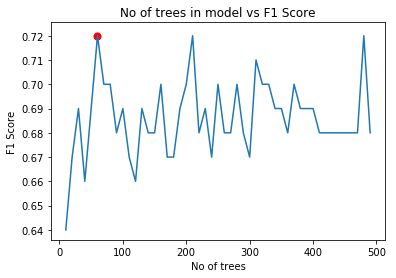

In [93]:
plt.show()

In [87]:
x=round((f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")+f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2
,2)

In [98]:
scoreoptimal

0.71999999999999997

In [94]:
noptimal

60

In [97]:
class_rf_opt = RandomForestClassifier(n_estimators=60,max_features="sqrt",random_state=1)
class_rf_opt.fit(x_train,y_train)
y_pred = class_rf_opt.predict(x_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          D       0.73      0.51      0.60        78
          R       0.68      0.84      0.75        94

avg / total       0.70      0.69      0.68       172

